In [1]:
# 코드 10-25 라이브러리 호출
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import os
import io
import re
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

2024-12-03 11:57:50.788546: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2024-12-03 11:57:50.788585: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# 코드 10-26 데이터셋 전처리 함수 정의
import unicodedata


def unicode_to_ascii(s):
    return "".join(
        c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn"
    )


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())  # 소문자로 전환
    w = re.sub(r"([?.!,¿])", r" \1 ", w)  # 특수 문자 제거
    # 단어와 그 뒤에 오는 구두점 사이에 공백을 삽입(예 “she is here.” → “she is here . ”)
    w = re.sub(r'[" "]+', " ", w)
    # a-z, A-Z, ., ?, ! 등을 제외하고 모두 공백으로 바꿈
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.rstrip().strip()  # 공백 문자 제거
    # 문장의 시작 <start>와 종료 <end> 토큰 생성(모델이 예측을 시작하고 종료할 시기를 알 수 있도록 시작과 끝을 지정)
    w = "<start> " + w + " <end>"
    return w

In [3]:
# 코드 10-27 데이터 전처리 확인
en_sentence = "May I borrow this book?"
sp_sentence = "¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode("utf-8"))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [4]:
# 코드 10-28 [ENGLISH, SPANISH] 형식의 단어 반환
def create_dataset(path, num_examples):
    lines = io.open(path, encoding="UTF-8").read().strip().split("\n")

    word_pairs = [
        [preprocess_sentence(w) for w in l.split("\t")] for l in lines[:num_examples]
    ]

    return zip(*word_pairs)


def max_length(tensor):
    return max(len(t) for t in tensor)


def tokenize(lang):  # 문장의 토큰화
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters="")
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding="post")

    return tensor, lang_tokenizer


def load_dataset(path, num_examples=None):  # 입력/출력(english, spanish) 쌍 만들기
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [5]:
# 코드 10-29 데이터셋 크기 조정
num_examples = 30000  # 다양한 세트로 수행해 보는 것도 좋습니다.
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(
    "data/spa.txt", num_examples
)

# 대상 텐서의 최대 길이(max_length) 계산
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

# 8:2 비율로 훈련과 검증
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = (
    train_test_split(input_tensor, target_tensor, test_size=0.2)
)

In [6]:
# 코드 10-30 하이퍼파라미터 초기화
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

# 데이터 분석을 위한 데이터셋 분리
dataset = tf.data.Dataset.from_tensor_slices(
    (input_tensor_train, target_tensor_train)
).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

2024-12-03 11:57:52.949660: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2024-12-03 11:57:53.103439: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:968] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-03 11:57:53.103470: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.759GHz coreCount: 20 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 298.32GiB/s
2024-12-03 11:57:53.103538: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2024-12-03 11:57:53.103590: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic 

In [7]:
# 코드 10-31 인코더 네트워크 구축


class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # 7장에서 학습했던 GRU를 이용한 모델 생성
        self.gru = tf.keras.layers.GRU(
            self.enc_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
        )

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))  # 은닉층 초기화


encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

In [8]:
# 코드 10-32 어텐션 구축
class EDAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(EDAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))
        # 어텐션 가중치(attention_weights)의 형태는 (배치 크기, 시퀀스 최대 길이, 1)이 됩니다.
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        # 컨텍스트 벡터(context_vector)의 형태는 (배치 크기, 은닉층 크기)입니다.
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights


attention_layer = EDAttention(10)

In [9]:
# 코드 10-33 디코더 네트워크 구축
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(
            self.dec_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
        )
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = EDAttention(self.dec_units)  # 어텐션 적용

    # 인코더 출력(enc_output) 형태는 (배치 크기, 시퀀스 최대 길이, 은닉층 크기)입니다.
    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        # 임베딩층을 통과한 후 x의 형태는 (배치 크기, 1, 임베딩 차원)입니다.
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)  # 병합된 벡터를 GRU로 보냅니다.
        # 출력 형태는 (배치 크기×1, 은닉층 크기)입니다.
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attention_weights


decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [10]:
# 코드 10-34 옵티마이저 및 손실 함수 정의
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [11]:
# 코드 10-35 체크포인트 설정
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    optimizer=optimizer,
    encoder=encoder,
    decoder=decoder,
)

In [12]:
# 코드 10-36 모델 훈련 함수 정의
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang.word_index["<start>"]] * BATCH_SIZE, 1)
        for t in range(1, targ.shape[1]):  # 대상 단어를 입력으로 사용
            # 인코더 출력(enc_output)을 디코더로 보냅니다.
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = loss / int(targ.shape[1])  # 손실/오차 계산
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [13]:
# 코드 10-37 모델 훈련
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for batch, (inp, targ) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print(f"Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}")

    if (epoch + 1) % 2 == 0:  # 2 에포크마다 모델을 체크포인트에 저장
        checkpoint.save(file_prefix=checkpoint_prefix)

    print(f"Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}")

print(f"Time taken for 1 epoch {time.time()-start} sec")

Epoch 1 Batch 0 Loss 4.5420
Epoch 1 Batch 100 Loss 2.2810
Epoch 1 Batch 200 Loss 1.7662
Epoch 1 Batch 300 Loss 1.6393
Epoch 1 Loss 2.0463
Epoch 2 Batch 0 Loss 1.6065
Epoch 2 Batch 100 Loss 1.4443
Epoch 2 Batch 200 Loss 1.4452
Epoch 2 Batch 300 Loss 1.3314
Epoch 2 Loss 1.4041
Epoch 3 Batch 0 Loss 1.0169
Epoch 3 Batch 100 Loss 1.0833
Epoch 3 Batch 200 Loss 1.0142
Epoch 3 Batch 300 Loss 0.9419
Epoch 3 Loss 0.9901
Epoch 4 Batch 0 Loss 0.7444
Epoch 4 Batch 100 Loss 0.6667
Epoch 4 Batch 200 Loss 0.6123
Epoch 4 Batch 300 Loss 0.7073
Epoch 4 Loss 0.6742
Epoch 5 Batch 0 Loss 0.4340
Epoch 5 Batch 100 Loss 0.4460
Epoch 5 Batch 200 Loss 0.4910
Epoch 5 Batch 300 Loss 0.5144
Epoch 5 Loss 0.4594
Epoch 6 Batch 0 Loss 0.2921
Epoch 6 Batch 100 Loss 0.2937
Epoch 6 Batch 200 Loss 0.3131
Epoch 6 Batch 300 Loss 0.2570
Epoch 6 Loss 0.3182
Epoch 7 Batch 0 Loss 0.1973
Epoch 7 Batch 100 Loss 0.1899
Epoch 7 Batch 200 Loss 0.2280
Epoch 7 Batch 300 Loss 0.2271
Epoch 7 Loss 0.2266
Epoch 8 Batch 0 Loss 0.1659
Epoch 

In [14]:
# 코드 10-38 모델 평가 및 시각화를 위한 함수
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(" ")]
    inputs = tf.keras.preprocessing.sequence.pad_sequences(
        [inputs], maxlen=max_length_inp, padding="post"
    )
    inputs = tf.convert_to_tensor(inputs)
    result = ""
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index["<start>"]], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(
            dec_input, dec_hidden, enc_out
        )
        attention_weights = tf.reshape(attention_weights, (-1,))  # 어텐션 가중치
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + " "
        if targ_lang.index_word[predicted_id] == "<end>":
            return result, sentence, attention_plot
        dec_input = tf.expand_dims(
            [predicted_id], 0
        )  # 예측된 ID가 모델에 피드백됩니다.

    return result, sentence, attention_plot

In [15]:
# 코드 10-39 어텐션 가중치 시각화 함수
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap="viridis")

    fontdict = {"fontsize": 14}

    ax.set_xticklabels([""] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([""] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


/tmp/ipykernel_807500/2557474208.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_807500/2557474208.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""] + predicted_sentence, fontdict=fontdict)


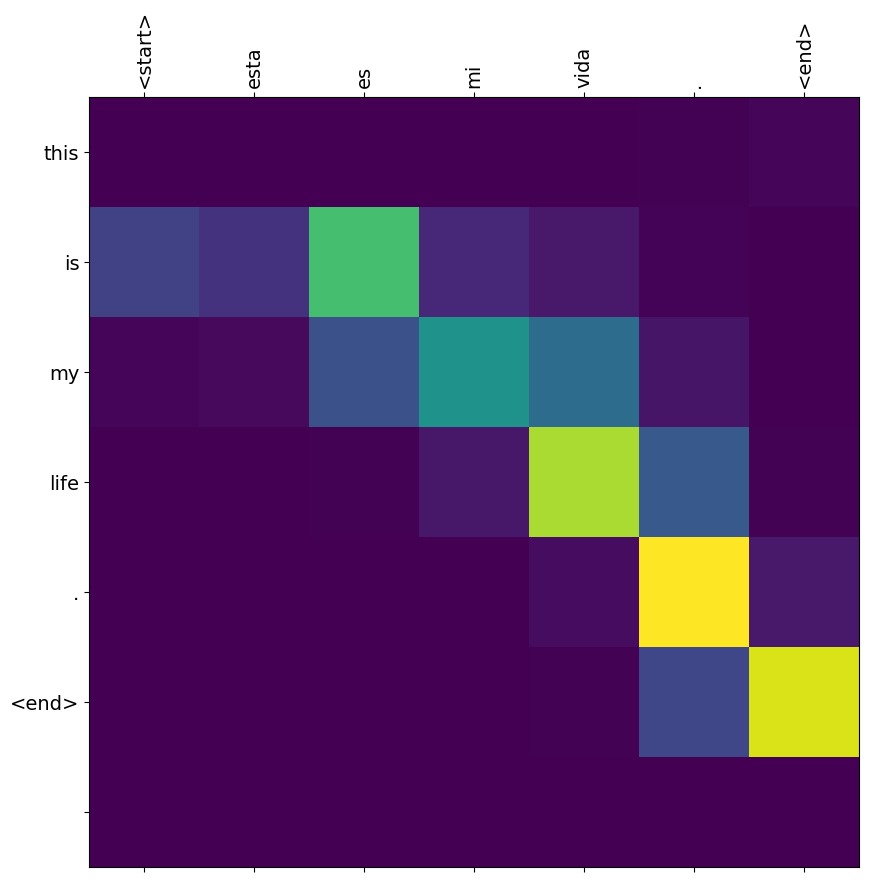

In [16]:
# 코드 10-40 번역을 위한 함수 정의 및 번역 문장 입력 함수
import numpy as np
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print("Input: %s" % (sentence))
    print("Predicted translation: {}".format(result))

    attention_plot = attention_plot[
        : len(result.split(" ")), : len(sentence.split(" "))
    ]
    plot_attention(
        attention_plot, sentence.split(" "), result.split(" ")
    )  # 어텐션 가중치 매핑


checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

translate("esta es mi vida.")  # 스페인어를 영어로 번역